In [1]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from skimage.transform import resize

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 100
NUM_EPOCHS = 10

import uuid
arr_guid = [str(uuid.uuid4()) for i in range(BATCH_SIZE*NUM_CLASSES)] 

# importing copy module 
import copy 

classes = []
c_obj = {
    'meta' : {},
    'layers': []
}

# using deepcopy for deepcopy 
for i in range(10):
    tmpX = copy.deepcopy(c_obj)
    tmpX['meta']['name'] = 'class' + str(i)
    classes.append(tmpX)



In [3]:
# LOAD CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
# Instantiate the model 
# https://keras.io/api/applications/resnet/#resnet-and-resnetv2
# TODO : upscaling 32x32 
#        When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).

input_shape = (32, 32, 3)


base_model = {}
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
#base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')

#print(base_model.summary())

C:\Users\benza-ord\anaconda3\envs\keras-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [5]:
add_layers = [37,79,141,173]
for idx in range(len(add_layers)):
    print(idx, base_model.get_layer(index = add_layers[idx]).name)
    #print(idx, base_model.get_layer(index = idx).__class__.__name__)
    


0 add_3
1 add_7
2 add_13
3 add_16


In [6]:
# prepare the batches here (ideally we want BATCH_SIZE samples for all NUM_CLASSES classes)
all_classes = np.unique(y_test)

# total batch images:
mini_batches = []

mini_y = []

for c_i in all_classes:
    result = np.where(y_test == c_i)
    batch = result[0][:BATCH_SIZE].astype(int)
    
    mini_y = np.concatenate((mini_y,batch))
    
    for idx in batch:
        mini_batches.append(x_test[idx])
        
        
mini_batches = np.stack(mini_batches)
print(mini_batches.shape)

mini_y = mini_y.astype(int)
print(mini_y.shape)


(1000, 32, 32, 3)
(1000,)


In [7]:
mini_batches = mini_batches/255.0
np.min(mini_batches),np.max(mini_batches)

(0.0, 1.0)

In [8]:
# Import PCA from sklearn
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt 



for idx in range(len(add_layers)):
    
    x = base_model.layers[add_layers[idx]+1].output
    x = GlobalAveragePooling2D()(x)
    model_cut = Model(inputs = base_model.input, outputs = x)
    
    pred = model_cut.predict(mini_batches)
    
    
    # Instantiate PCA
    pca = PCA(n_components=3)
    X = pca.fit_transform(pred)

    print(X.shape)
    X = X[:,:2]  #just keep the two columns for visualization
    """
    # Create a new dataset from principal components 
    df = pd.DataFrame(data = X, columns = ['PC1', 'PC2'])

    target = pd.Series(np.array(y_test[mini_y]).flatten(), name='y')

    result_df = pd.concat([df, target], axis=1)
    
    
    # Visualize Principal Components with a scatter plot
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('First Principal Component ', fontsize = 15)
    ax.set_ylabel('Second Principal Component ', fontsize = 15)
    ax.set_title('Principal Component Analysis (2PCs)', fontsize = 20)

    targets = np.unique(y_test)
    colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
    for target, color in zip(targets, colors):
        indicesToKeep = result_df.loc[result_df['y'] == target]
        ax.scatter(indicesToKeep['PC1'], 
                   indicesToKeep['PC2'], 
                   c = color, 
                   s = 50)
    ax.legend(targets)
    ax.grid()
    """
    
    tmp_layers = []
        
    
    
    for idx, i in enumerate(X):
        quotient = int(idx / BATCH_SIZE)
        remainder = int(idx % BATCH_SIZE)
        
        point = {
            'x': str(i[0]),
            'y': str(i[1]),
            'pred': str(y_test[mini_y[idx]][0]),
            'actual': str(y_test[mini_y[idx]][0]),
            'guid': arr_guid[idx]
        }
        
        
        
        if idx > 0 and remainder == 0:
            #print(idx, quotient, remainder)
            # we know batch of 1 class is complete
            classes[quotient-1]['layers'].append(tmp_layers)
            tmp_layers = []
        
        if idx == len(X)-1:
            classes[quotient]['layers'].append(tmp_layers)
            tmp_layers = []
            
        tmp_layers.append(point)
    

    

(1000, 3)
(1000, 3)
(1000, 3)
(1000, 3)


In [11]:
from PIL import Image

for f in os.listdir('..\\..\\data\\v1\\images\\'):
    os.remove(os.path.join(mydir, f))

for idx, i in enumerate(arr_guid):
    x_index = mini_y[idx]
    image = Image.fromarray(x_test[x_index])
    image.save('..\\..\\data\\v1\\images\\'+i+'.png')

print('done')


In [61]:
import os
print(os.path.abspath('..\\data\\v1\\images\\'))

C:\Users\benza-ord\source\repos\CS529-ML-Final-Project\backend\data\v1\images


In [10]:
import json 

result = {}
result["n_layers"] = str(len(add_layers))
result["classes"] = classes

with open('..\\..\\data\\v1\\block_resnet50.json', 'w') as outfile:
    json.dump(result, outfile)

In [47]:
classes

[{'meta': {'name': 'class0'},
  'layers': [[{'x': '0.024133211',
     'y': '-0.16117816',
     'pred': '0',
     'actual': '0',
     'guid': '730a22db-2271-4159-87d4-f4d5c839e5a4'},
    {'x': '-0.17518528',
     'y': '0.042322975',
     'pred': '0',
     'actual': '0',
     'guid': 'f26ff7f3-ff02-49d6-8e0b-02631edfc39e'},
    {'x': '0.47281125',
     'y': '0.2128401',
     'pred': '0',
     'actual': '0',
     'guid': '71fd0938-5622-401f-a0d8-3c295faa63bc'},
    {'x': '0.02146718',
     'y': '0.025235943',
     'pred': '0',
     'actual': '0',
     'guid': 'e17c05e9-1c4e-4fbe-a951-f618071531a8'},
    {'x': '-0.2260143',
     'y': '-0.13443956',
     'pred': '0',
     'actual': '0',
     'guid': 'cd546194-3be1-41d6-97ed-14c33336404c'},
    {'x': '0.05124242',
     'y': '0.183011',
     'pred': '0',
     'actual': '0',
     'guid': 'a2688d76-62e2-41f4-8f8c-cf9e0a4369e4'},
    {'x': '0.037411246',
     'y': '-0.058482464',
     'pred': '0',
     'actual': '0',
     'guid': '6f286920-8836-

In [117]:
    
# Import PCA from sklearn
from sklearn.decomposition import PCA
import pandas as pd

# Instantiate PCA
pca = PCA(n_components=3)
X = pca.fit_transform(pred)

print(X.shape)
X = X[:,:2]  #just keep the two columns for visualization

# Create a new dataset from principal components 
df = pd.DataFrame(data = X, columns = ['PC1', 'PC2'])

target = pd.Series(np.array(y_test[0:1000]).flatten(), name='y')

result_df = pd.concat([df, target], axis=1)

result_df

(1000, 3)


,PC1,PC2,y
0,0.001544,-0.006727,3
1,-0.014006,0.007507,8
2,0.002173,0.007797,8
3,-0.004487,0.012092,0
4,0.003476,-0.007729,6
...,...,...,...
995,0.000169,-0.002387,3
996,0.003401,0.004294,8
997,-0.013037,-0.010347,1
998,0.008234,-0.006186,3


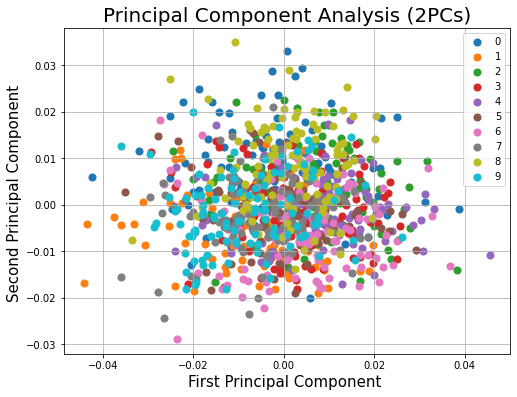

In [119]:
# Visualize Principal Components with a scatter plot
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('First Principal Component ', fontsize = 15)
ax.set_ylabel('Second Principal Component ', fontsize = 15)
ax.set_title('Principal Component Analysis (2PCs)', fontsize = 20)

targets = np.unique(y_test)
#targets = [4,1]
colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
#colors = ["#1f77b4","#ff7f0e"]
for target, color in zip(targets, colors):
    indicesToKeep = result_df.loc[result_df['y'] == target]
    ax.scatter(indicesToKeep['PC1'], 
               indicesToKeep['PC2'], 
               c = color, 
               s = 50)
ax.legend(targets)
ax.grid()


In [65]:
# alternate method
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs = base_model.input, outputs = x)

#model = keras.Sequential(
#    [
#       base_model,
#        keras.layers.Flatten(),
#        keras.layers.Dense(1024, activation="relu"),
#        keras.layers.Dense(10, activation="softmax"),
#    ]
#)


In [7]:
#image = np.expand_dims(x_test[0], axis=0)
image = x_test[0:1000]
pred = model_cut.predict(image)

pred.shape

NameError: name 'model_cut' is not defined